# STZ Flow Curve Fitting

**Shear Transformation Zone (STZ) model — Steady-state flow curve**

## Learning Objectives

- Understand the STZ theory: effective temperature chi, activation barriers, and plastic flow
- Fit steady-state flow curves using the analytical arctanh formula
- Visualize C(sigma) and T(sigma) kernel functions
- Perform Bayesian inference with NUTS and evaluate convergence
- Calibrate parameters for use in subsequent STZ notebooks

## Prerequisites

- Basic familiarity with rheological flow curves sigma(gamma_dot)
- Understanding of NLSQ fitting (see `01-basic-maxwell.ipynb`)
- Understanding of Bayesian inference basics (see `05-bayesian-basics.ipynb`)

## Estimated Runtime

- Fast demo (1 chain): ~1-2 min
- Full run (4 chains): ~4-6 min

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.stz import STZConventional

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Shear Transformation Zones

The STZ model (Falk & Langer 1998, Langer 2008) describes plastic flow in **amorphous solids** — metallic glasses, colloidal glasses, dense emulsions — via localized rearrangements called *Shear Transformation Zones*.

### Key concepts

**Effective temperature** $\chi$: A configurational entropy measure of structural disorder. Unlike thermal temperature, $\chi$ is driven by mechanical work and controls the density of STZs:

$$\Lambda = \exp(-e_z / \chi)$$

where $e_z$ is the STZ formation energy and $\Lambda$ is the equilibrium STZ density.

**Rate factor** $\mathcal{C}(\sigma) = \cosh(\sigma / \sigma_y)$ — total transition rate (forward + backward).

**Transition bias** $\mathcal{T}(\sigma) = \tanh(\sigma / \sigma_y)$ — net directional bias of transformations.

**Plastic strain rate:**

$$\dot{\gamma}_{\text{pl}} = \frac{2 \epsilon_0}{\tau_0} \, \Lambda \, \exp(-1/\chi) \, \mathcal{C}(\sigma) \, \mathcal{T}(\sigma)$$

### Steady-state flow curve

At steady state, $\chi \to \chi_{\infty}$ and the combined activation factor simplifies. Setting $\dot{\gamma} = \dot{\gamma}_{\text{pl}}$ and inverting yields the **arctanh formula**:

$$\sigma = \sigma_y \cdot \text{arctanh}\!\left(\frac{\dot{\gamma} \, \tau_0}{\exp\!\left[-(1 + e_z)/\chi_{\infty}\right]}\right)$$

This is **analytical** (no ODE integration), making flow curve fitting fast.

### Parameters for steady state

| Parameter | Symbol | Physical meaning |
|-----------|--------|------------------|
| `sigma_y` | $\sigma_y$ | Yield stress — activation barrier scale |
| `chi_inf` | $\chi_{\infty}$ | Steady-state effective temperature |
| `tau0` | $\tau_0$ | Molecular attempt time |
| `ez` | $e_z$ | STZ formation energy |

**Note:** G0, epsilon0, c0, and tau_beta only affect *transient* response and are **not identifiable** from steady-state data alone.

### Synthetic Data Strategy

We generate **synthetic flow curve data** from the STZ arctanh formula with known parameters, then add 3% log-normal noise. This ensures the model-data compatibility is exact, letting us focus on the fitting workflow and parameter identifiability.

The STZ arctanh formula was derived for amorphous solids where the transition from thermally-activated creep to driven flow is sharp. Real yield-stress materials (emulsions, colloidal gels) often show smoother Herschel-Bulkley behavior that the arctanh shape cannot capture. Notebooks 03-05 use real experimental data with other protocols (relaxation, creep, SAOS) where STZ performs well via ODE integration.

## 3. Generate Synthetic Data

In [3]:
# Robust path resolution for execution from any directory
import sys
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_stz_candidates = [_nb_dir, Path("examples/stz"), _nb_dir.parent / "stz"]
for _p in _stz_candidates:
    if (_p / "stz_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break

from stz_tutorial_utils import generate_synthetic_flow_curve

gamma_dot, stress, true_params = generate_synthetic_flow_curve()

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: {gamma_dot.min():.4f} - {gamma_dot.max():.1f} 1/s")
print(f"Stress range: {stress.min():.4f} - {stress.max():.1f} Pa")
print("\nTrue parameters:")
for k, v in true_params.items():
    print(f"  {k:8s} = {v:.4g}")

Data points: 30
Shear rate range: 0.0010 - 1000.0 1/s
Stress range: 0.0051 - 376.3 Pa

True parameters:
  sigma_y  = 50
  chi_inf  = 0.26
  tau0     = 0.0001
  ez       = 0.8


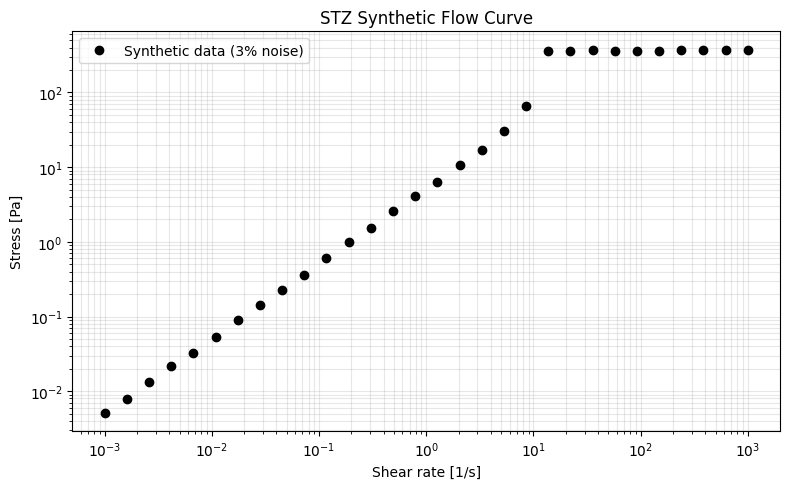

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Synthetic data (3% noise)")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("STZ Synthetic Flow Curve")
ax.grid(True, alpha=0.3, which="both")
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

The arctanh shape shows: linear Newtonian regime at low shear rates ($\sigma \propto \dot{\gamma}$), then a sharp upturn as the argument approaches unity. This transition is controlled by $\tau_0$ and $\chi_{\infty}$, while the overall stress scale is set by $\sigma_y$.

## 4. NLSQ Fitting

In [5]:
import time
from stz_tutorial_utils import compute_fit_quality

model = STZConventional(variant="standard")

# Non-identifiable params: constrain to tight bounds (they don't affect steady state
# but large values cause the optimizer to stall via xtol)
model.parameters.set_bounds("G0", (0.5, 2.0))
model.parameters["G0"].value = 1.0
model.parameters.set_bounds("epsilon0", (0.05, 0.2))
model.parameters["epsilon0"].value = 0.1
model.parameters.set_bounds("c0", (0.5, 2.0))
model.parameters["c0"].value = 1.0
model.parameters.set_bounds("tau_beta", (0.5, 2.0))
model.parameters["tau_beta"].value = 1.0

# Identifiable params — set bounds and initial guesses (offset from true values)
model.parameters.set_bounds("sigma_y", (1.0, 500.0))
model.parameters["sigma_y"].value = 30.0
model.parameters.set_bounds("chi_inf", (0.05, 0.5))
model.parameters["chi_inf"].value = 0.20
model.parameters.set_bounds("tau0", (1e-8, 1e0))
model.parameters["tau0"].value = 1e-3
model.parameters.set_bounds("ez", (0.1, 5.0))
model.parameters["ez"].value = 1.5

t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve", use_log_residuals=True, method='scipy')
t_nlsq = time.time() - t0

stress_at_data = model.predict(gamma_dot)
quality = compute_fit_quality(stress, stress_at_data)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R-squared: {quality['r_squared']:.6f}")
print(f"RMSE: {quality['rmse']:.4f} Pa")
print("\nFitted vs true parameters (steady-state):")
for name in ["sigma_y", "chi_inf", "tau0", "ez"]:
    fitted = model.parameters.get_value(name)
    true = true_params[name]
    print(f"  {name:8s} = {fitted:.4g}  (true: {true:.4g})")

NLSQ fit time: 0.47 s
R-squared: 0.999581
RMSE: 3.4561 Pa

Fitted vs true parameters (steady-state):
  sigma_y  = 50.13  (true: 50)
  chi_inf  = 0.2567  (true: 0.26)
  tau0     = 0.0004497  (true: 0.0001)
  ez       = 0.3904  (true: 0.8)


### 4.1 Fit Quality

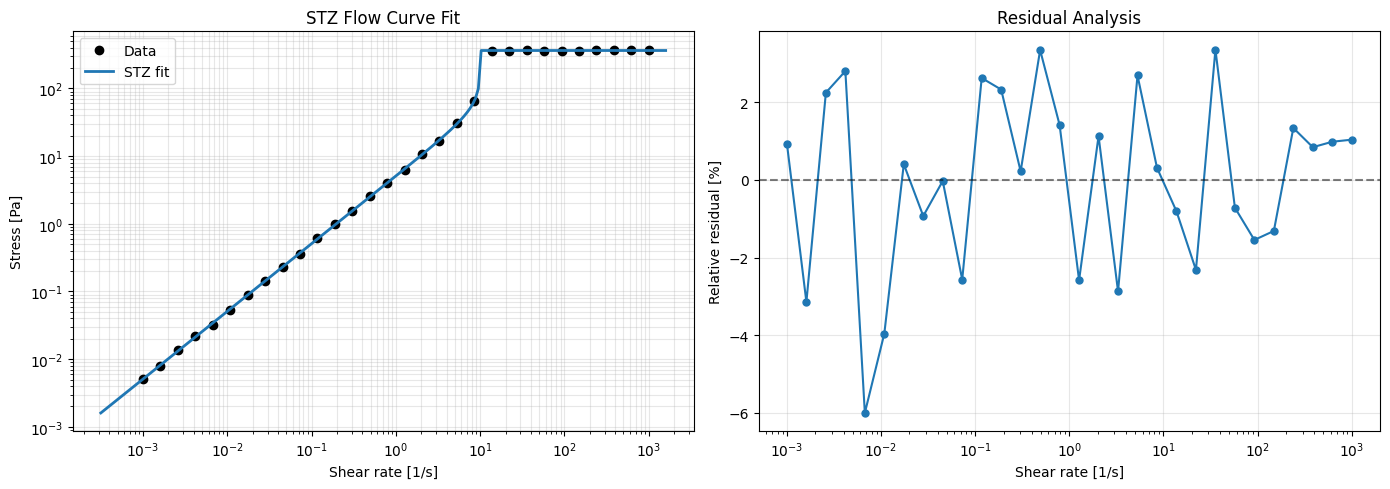

In [6]:
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.2,
    200,
)
stress_pred = model.predict(gamma_dot_fine)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: flow curve
ax1.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax1.loglog(gamma_dot_fine, stress_pred, "-", lw=2, color="C0", label="STZ fit")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("STZ Flow Curve Fit")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Right: residuals
stress_at_data = model.predict(gamma_dot)
res = (stress - stress_at_data) / stress * 100
ax2.semilogx(gamma_dot, res, "o-", markersize=5, color="C0")
ax2.axhline(0, color="black", linestyle="--", alpha=0.5)
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Relative residual [%]")
ax2.set_title("Residual Analysis")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Physics Insight: C(sigma) and T(sigma) Kernels

The rate factor $\mathcal{C}$ and transition bias $\mathcal{T}$ are the two fundamental kernels that control STZ dynamics. Let's visualize them with the fitted yield stress.

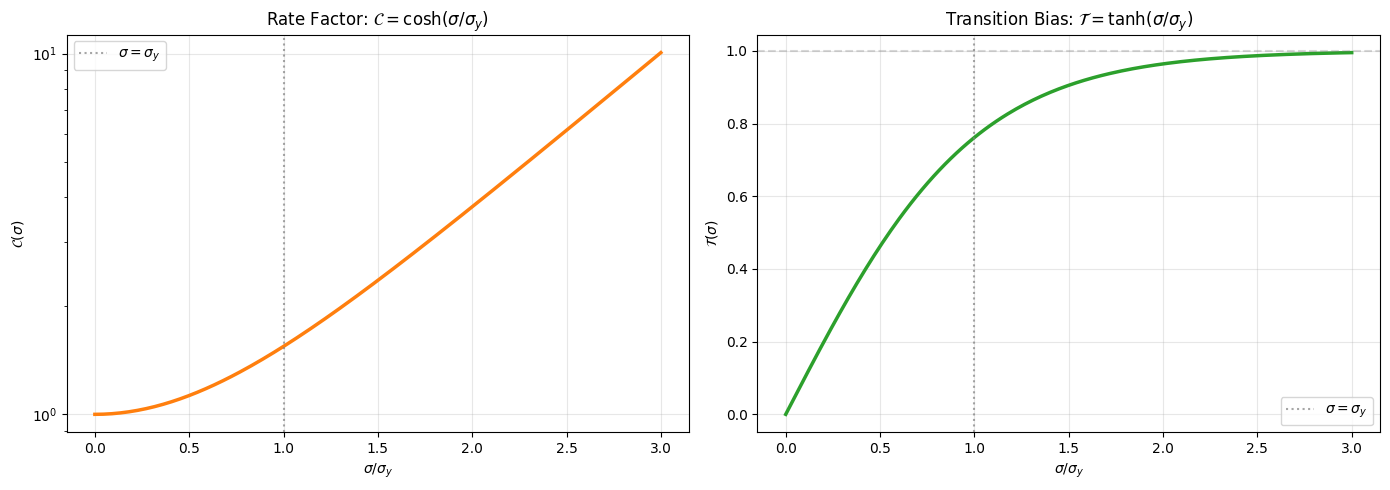

In [7]:
from rheojax.models.stz._kernels import rate_factor_C, transition_T

sigma_y_fit = model.parameters.get_value("sigma_y")
sigma_range = np.linspace(0, 3 * sigma_y_fit, 200)

C_vals = np.array([float(rate_factor_C(s, sigma_y_fit)) for s in sigma_range])
T_vals = np.array([float(transition_T(s, sigma_y_fit)) for s in sigma_range])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(sigma_range / sigma_y_fit, C_vals, "-", lw=2.5, color="C1")
ax1.axvline(1.0, color="gray", linestyle=":", alpha=0.7, label="$\\sigma = \\sigma_y$")
ax1.set_xlabel("$\\sigma / \\sigma_y$")
ax1.set_ylabel("$\\mathcal{C}(\\sigma)$")
ax1.set_title("Rate Factor: $\\mathcal{C} = \\cosh(\\sigma/\\sigma_y)$")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(sigma_range / sigma_y_fit, T_vals, "-", lw=2.5, color="C2")
ax2.axvline(1.0, color="gray", linestyle=":", alpha=0.7, label="$\\sigma = \\sigma_y$")
ax2.axhline(1.0, color="gray", linestyle="--", alpha=0.3)
ax2.set_xlabel("$\\sigma / \\sigma_y$")
ax2.set_ylabel("$\\mathcal{T}(\\sigma)$")
ax2.set_title("Transition Bias: $\\mathcal{T} = \\tanh(\\sigma/\\sigma_y)$")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

- **$\mathcal{C}(\sigma)$** grows exponentially above $\sigma_y$, accelerating total rearrangement rate.
- **$\mathcal{T}(\sigma)$** saturates at 1.0 for $\sigma \gg \sigma_y$, meaning all transformations are forward-biased.
- Below $\sigma_y$: forward and backward transformations nearly cancel ($\mathcal{T} \approx 0$), so no net plastic flow.

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

In [8]:
# Warm-start values from NLSQ
initial_values = {
    name: model.parameters.get_value(name)
    for name in model.parameters.keys()
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")

# --- Fast demo config ---
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  G0: 1
  sigma_y: 50.13
  chi_inf: 0.2567
  tau0: 0.0004497
  epsilon0: 0.1
  c0: 1
  ez: 0.3904
  tau_beta: 1


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<08:57,  1.30it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 6/700 [00:00<01:18,  8.90it/s, 1023 steps of size 2.42e-04. acc. prob=0.41]

warmup:   2%|▏         | 13/700 [00:00<00:34, 19.65it/s, 1023 steps of size 2.32e-04. acc. prob=0.73]

warmup:   3%|▎         | 19/700 [00:01<00:24, 27.67it/s, 1023 steps of size 4.28e-04. acc. prob=0.81]

warmup:   4%|▎         | 25/700 [00:01<00:21, 31.28it/s, 1023 steps of size 8.19e-04. acc. prob=0.86]

warmup:   4%|▍         | 30/700 [00:01<00:19, 34.11it/s, 1023 steps of size 1.34e-03. acc. prob=0.88]

warmup:   5%|▌         | 36/700 [00:01<00:17, 39.03it/s, 1023 steps of size 2.12e-03. acc. prob=0.90]

warmup:   6%|▋         | 44/700 [00:01<00:13, 47.33it/s, 1023 steps of size 2.31e-03. acc. prob=0.91]

warmup:   7%|▋         | 51/700 [00:01<00:12, 52.56it/s, 1023 steps of size 2.61e-03. acc. prob=0.92]

warmup:   8%|▊         | 57/700 [00:01<00:13, 48.27it/s, 1023 steps of size 3.12e-03. acc. prob=0.93]

warmup:   9%|▉         | 63/700 [00:01<00:12, 49.86it/s, 1023 steps of size 2.29e-03. acc. prob=0.93]

warmup:  10%|▉         | 69/700 [00:02<00:13, 46.44it/s, 1023 steps of size 2.28e-03. acc. prob=0.93]

warmup:  11%|█         | 76/700 [00:02<00:12, 51.86it/s, 1023 steps of size 2.59e-03. acc. prob=0.94]

warmup:  12%|█▏        | 82/700 [00:02<00:11, 53.49it/s, 207 steps of size 3.24e-03. acc. prob=0.94] 

warmup:  13%|█▎        | 88/700 [00:02<00:12, 48.69it/s, 1023 steps of size 2.38e-03. acc. prob=0.94]

warmup:  13%|█▎        | 94/700 [00:02<00:12, 47.59it/s, 1023 steps of size 2.60e-03. acc. prob=0.94]

warmup:  14%|█▍        | 99/700 [00:02<00:14, 41.38it/s, 1023 steps of size 2.68e-03. acc. prob=0.94]

warmup:  15%|█▌        | 105/700 [00:02<00:13, 45.63it/s, 1023 steps of size 2.99e-03. acc. prob=0.94]

warmup:  16%|█▌        | 111/700 [00:02<00:12, 48.79it/s, 1023 steps of size 3.18e-03. acc. prob=0.94]

warmup:  17%|█▋        | 117/700 [00:03<00:12, 47.72it/s, 239 steps of size 3.71e-03. acc. prob=0.95] 

warmup:  18%|█▊        | 123/700 [00:03<00:11, 49.14it/s, 1023 steps of size 4.12e-03. acc. prob=0.95]

warmup:  18%|█▊        | 129/700 [00:03<00:12, 46.39it/s, 1023 steps of size 3.80e-03. acc. prob=0.95]

warmup:  19%|█▉        | 136/700 [00:03<00:10, 51.66it/s, 1023 steps of size 4.59e-03. acc. prob=0.95]

warmup:  20%|██        | 142/700 [00:03<00:11, 49.43it/s, 1023 steps of size 4.38e-03. acc. prob=0.95]

warmup:  21%|██        | 148/700 [00:03<00:12, 45.48it/s, 1023 steps of size 2.23e-03. acc. prob=0.95]

warmup:  22%|██▏       | 154/700 [00:03<00:11, 47.40it/s, 1023 steps of size 1.41e-03. acc. prob=0.95]

warmup:  23%|██▎       | 159/700 [00:03<00:11, 46.29it/s, 1023 steps of size 1.22e-03. acc. prob=0.95]

warmup:  24%|██▎       | 165/700 [00:04<00:10, 49.68it/s, 1023 steps of size 1.54e-03. acc. prob=0.95]

warmup:  24%|██▍       | 171/700 [00:04<00:10, 48.31it/s, 1023 steps of size 2.04e-03. acc. prob=0.95]

warmup:  25%|██▌       | 178/700 [00:04<00:09, 52.79it/s, 1023 steps of size 2.81e-03. acc. prob=0.95]

warmup:  26%|██▋       | 184/700 [00:04<00:09, 54.35it/s, 1023 steps of size 3.11e-03. acc. prob=0.96]

warmup:  27%|██▋       | 190/700 [00:04<00:09, 53.97it/s, 1023 steps of size 3.73e-03. acc. prob=0.96]

warmup:  28%|██▊       | 196/700 [00:04<00:09, 52.51it/s, 1023 steps of size 4.37e-03. acc. prob=0.96]

sample:  29%|██▉       | 202/700 [00:04<00:10, 49.35it/s, 1023 steps of size 3.34e-03. acc. prob=1.00]

sample:  30%|██▉       | 208/700 [00:04<00:10, 48.22it/s, 1023 steps of size 3.34e-03. acc. prob=1.00]

sample:  31%|███       | 214/700 [00:05<00:09, 50.78it/s, 1023 steps of size 3.34e-03. acc. prob=1.00]

sample:  31%|███▏      | 220/700 [00:05<00:09, 52.53it/s, 1023 steps of size 3.34e-03. acc. prob=1.00]

sample:  33%|███▎      | 228/700 [00:05<00:08, 58.10it/s, 1023 steps of size 3.34e-03. acc. prob=1.00]

sample:  33%|███▎      | 234/700 [00:05<00:08, 57.23it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  34%|███▍      | 240/700 [00:05<00:08, 56.90it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  35%|███▌      | 246/700 [00:05<00:08, 55.97it/s, 1023 steps of size 3.34e-03. acc. prob=1.00]

sample:  36%|███▌      | 252/700 [00:05<00:08, 55.59it/s, 1023 steps of size 3.34e-03. acc. prob=1.00]

sample:  37%|███▋      | 259/700 [00:05<00:07, 58.14it/s, 511 steps of size 3.34e-03. acc. prob=1.00] 

sample:  38%|███▊      | 266/700 [00:05<00:07, 58.92it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  39%|███▉      | 272/700 [00:06<00:07, 57.00it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  40%|███▉      | 278/700 [00:06<00:08, 52.41it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  41%|████      | 286/700 [00:06<00:07, 58.77it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  42%|████▏     | 292/700 [00:06<00:07, 57.59it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  43%|████▎     | 299/700 [00:06<00:07, 56.58it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  44%|████▎     | 305/700 [00:06<00:08, 48.24it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  44%|████▍     | 311/700 [00:06<00:07, 50.35it/s, 511 steps of size 3.34e-03. acc. prob=0.99] 

sample:  45%|████▌     | 317/700 [00:06<00:07, 52.02it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  46%|████▌     | 323/700 [00:06<00:07, 51.97it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  47%|████▋     | 329/700 [00:07<00:06, 53.88it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  48%|████▊     | 335/700 [00:07<00:06, 55.44it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  49%|████▊     | 341/700 [00:07<00:07, 51.04it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  50%|████▉     | 347/700 [00:07<00:06, 50.83it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  50%|█████     | 353/700 [00:07<00:07, 47.39it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  51%|█████▏    | 360/700 [00:07<00:06, 51.03it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  52%|█████▏    | 366/700 [00:07<00:06, 50.72it/s, 511 steps of size 3.34e-03. acc. prob=0.99] 

sample:  53%|█████▎    | 372/700 [00:07<00:06, 51.80it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  54%|█████▍    | 378/700 [00:08<00:06, 52.55it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  55%|█████▍    | 384/700 [00:08<00:06, 51.10it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  56%|█████▌    | 390/700 [00:08<00:06, 49.73it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  57%|█████▋    | 396/700 [00:08<00:06, 49.13it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  57%|█████▋    | 401/700 [00:08<00:06, 48.09it/s, 175 steps of size 3.34e-03. acc. prob=0.99] 

sample:  58%|█████▊    | 406/700 [00:08<00:06, 45.90it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  59%|█████▉    | 413/700 [00:08<00:05, 50.88it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  60%|█████▉    | 419/700 [00:08<00:05, 52.98it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  61%|██████    | 425/700 [00:09<00:05, 49.05it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  61%|██████▏   | 430/700 [00:09<00:06, 41.85it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  62%|██████▏   | 435/700 [00:09<00:06, 42.45it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  63%|██████▎   | 441/700 [00:09<00:05, 44.77it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  64%|██████▍   | 448/700 [00:09<00:04, 51.03it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  65%|██████▌   | 456/700 [00:09<00:04, 58.04it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  66%|██████▋   | 464/700 [00:09<00:03, 60.66it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  67%|██████▋   | 471/700 [00:09<00:03, 61.68it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  68%|██████▊   | 478/700 [00:10<00:03, 56.40it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  69%|██████▉   | 484/700 [00:10<00:03, 56.53it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  70%|███████   | 491/700 [00:10<00:03, 58.52it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  71%|███████   | 498/700 [00:10<00:03, 60.23it/s, 399 steps of size 3.34e-03. acc. prob=0.99] 

sample:  72%|███████▏  | 505/700 [00:10<00:03, 53.40it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  73%|███████▎  | 511/700 [00:10<00:03, 49.52it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  74%|███████▍  | 517/700 [00:10<00:03, 50.54it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  75%|███████▍  | 523/700 [00:10<00:03, 48.35it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  75%|███████▌  | 528/700 [00:11<00:03, 47.77it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  76%|███████▌  | 533/700 [00:11<00:03, 47.04it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  77%|███████▋  | 539/700 [00:11<00:03, 47.43it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  78%|███████▊  | 546/700 [00:11<00:02, 51.63it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  79%|███████▉  | 552/700 [00:11<00:02, 50.96it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [00:11<00:02, 54.63it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  81%|████████  | 565/700 [00:11<00:02, 54.99it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  82%|████████▏ | 571/700 [00:11<00:02, 51.48it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  82%|████████▏ | 577/700 [00:11<00:02, 50.33it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  83%|████████▎ | 583/700 [00:12<00:02, 49.46it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  84%|████████▍ | 589/700 [00:12<00:02, 52.11it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  85%|████████▌ | 595/700 [00:12<00:01, 52.73it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  86%|████████▌ | 601/700 [00:12<00:02, 44.90it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  87%|████████▋ | 608/700 [00:12<00:01, 49.95it/s, 511 steps of size 3.34e-03. acc. prob=0.99] 

sample:  88%|████████▊ | 614/700 [00:12<00:01, 50.85it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [00:12<00:01, 49.47it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  89%|████████▉ | 626/700 [00:13<00:01, 40.89it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [00:13<00:01, 47.46it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  91%|█████████▏| 640/700 [00:13<00:01, 49.88it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  92%|█████████▏| 647/700 [00:13<00:01, 50.55it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [00:13<00:01, 44.70it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [00:13<00:00, 44.44it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  95%|█████████▍| 664/700 [00:13<00:00, 48.00it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  96%|█████████▌| 670/700 [00:13<00:00, 45.93it/s, 239 steps of size 3.34e-03. acc. prob=0.99] 

sample:  96%|█████████▋| 675/700 [00:14<00:00, 45.02it/s, 511 steps of size 3.34e-03. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [00:14<00:00, 44.99it/s, 511 steps of size 3.34e-03. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [00:14<00:00, 48.69it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample:  99%|█████████▉| 693/700 [00:14<00:00, 48.65it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample: 100%|█████████▉| 698/700 [00:14<00:00, 47.94it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:14<00:00, 48.10it/s, 1023 steps of size 3.34e-03. acc. prob=0.99]


Bayesian inference time: 18.5 s


### 5.2 Convergence Diagnostics

In [9]:
from stz_tutorial_utils import print_convergence_summary

param_names = ["sigma_y", "chi_inf", "tau0", "ez"]
print_convergence_summary(result, param_names)

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
--------------------------------------------------
     sigma_y    1.0000       500      PASS
     chi_inf    1.0000       500      PASS
        tau0    1.0000       500      PASS
          ez    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


True

### 5.3 ArviZ Diagnostic Plots

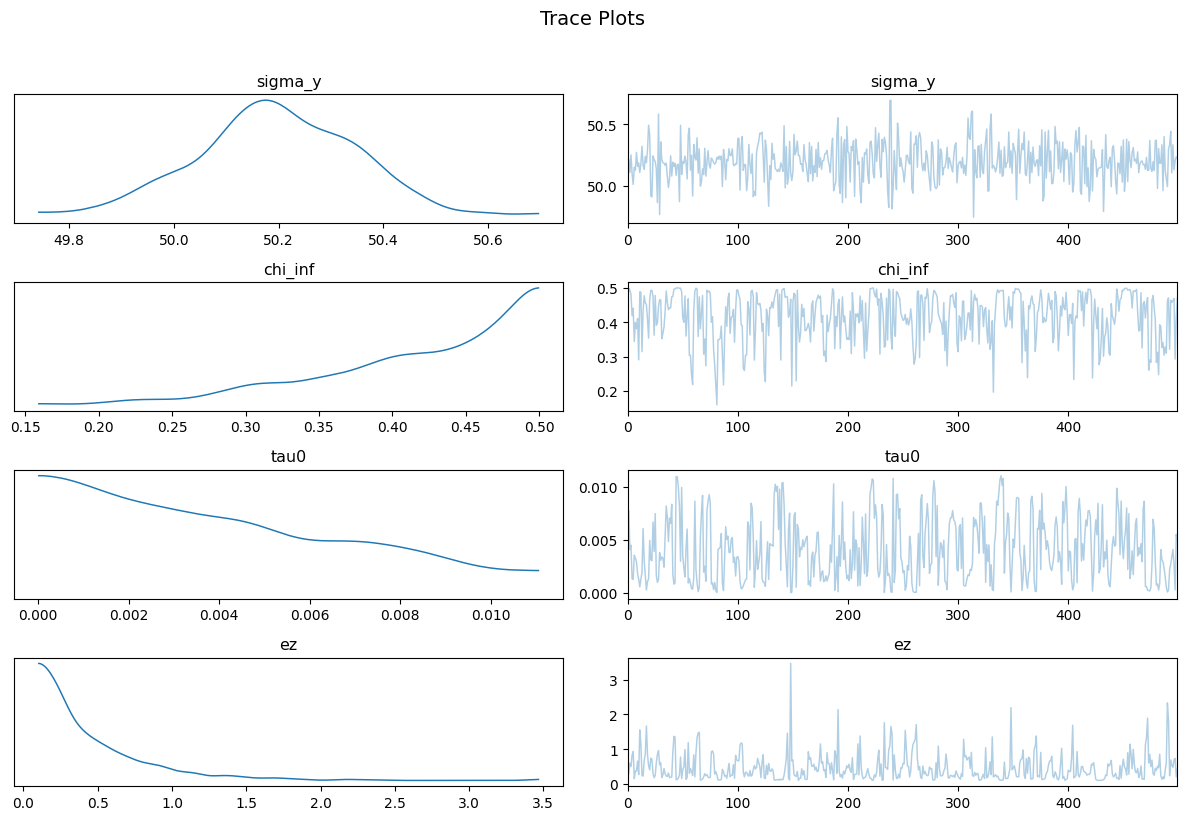

In [10]:
idata = result.to_inference_data()

# Trace plot
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

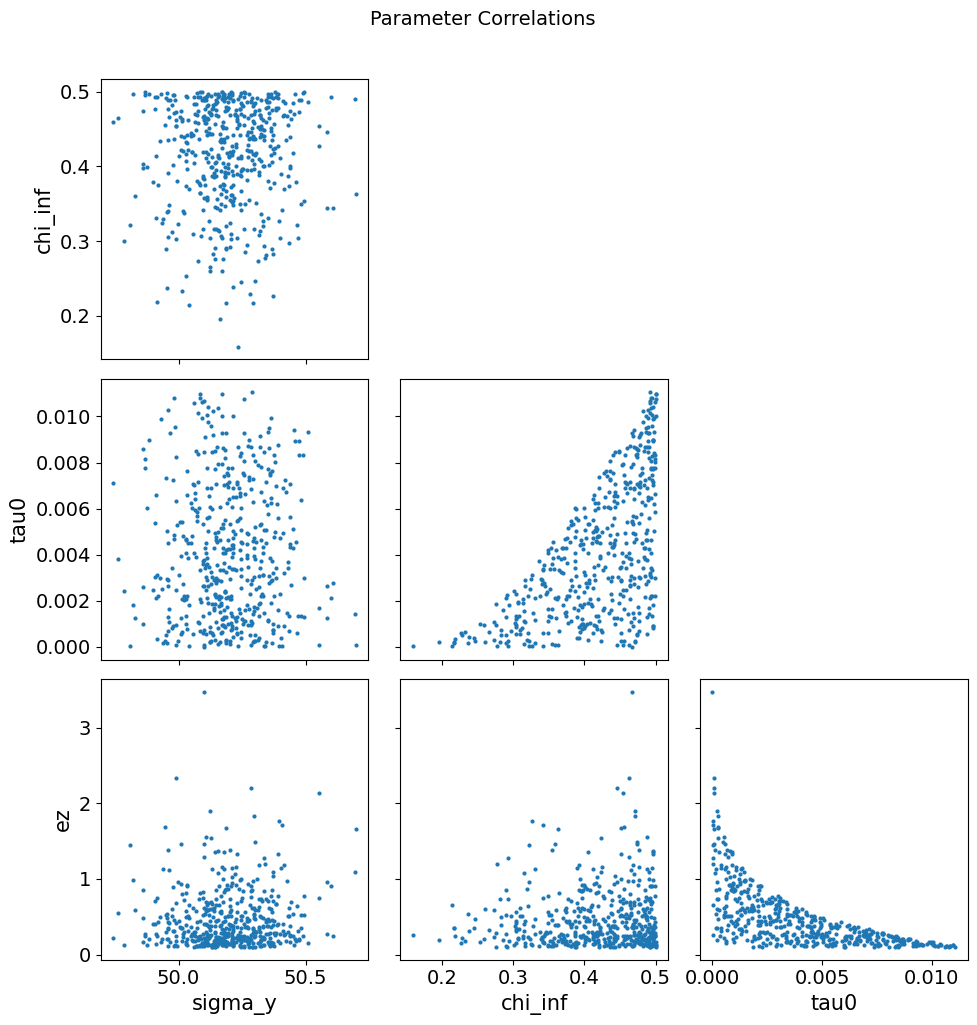

In [11]:
# Pair plot (parameter correlations)
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind="scatter",
    divergences=True,
    figsize=(10, 10),
)
fig = axes.ravel()[0].figure
fig.suptitle("Parameter Correlations", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

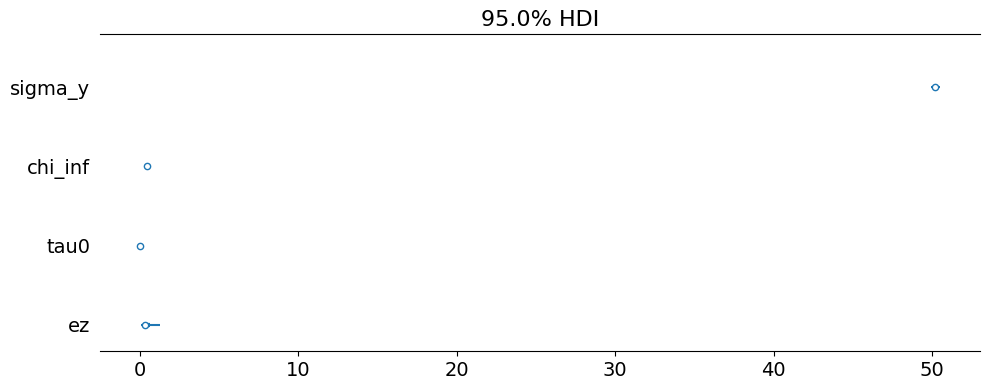

In [12]:
# Forest plot (credible intervals)
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 4),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.4 Posterior Predictive Check

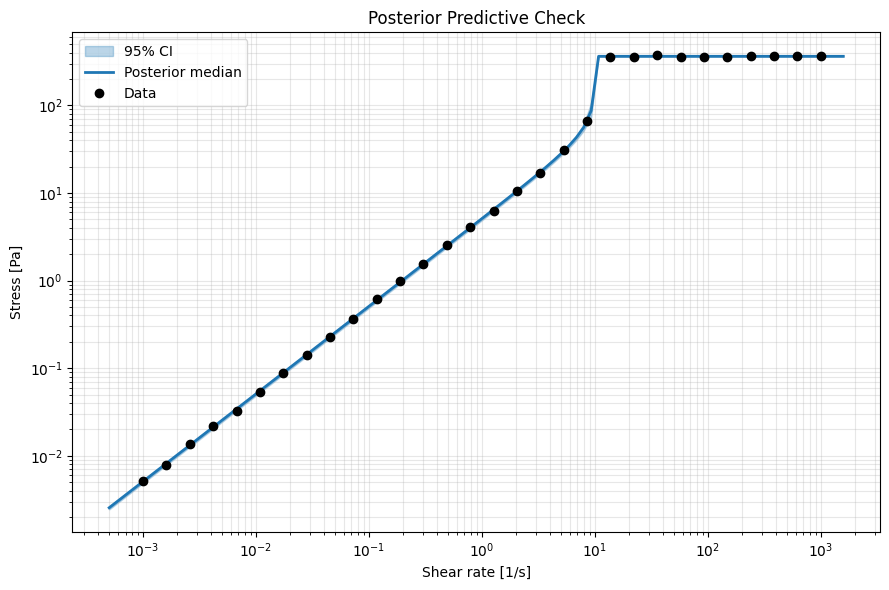

In [13]:
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))

gamma_dot_pred = np.logspace(
    np.log10(gamma_dot.min()) - 0.3,
    np.log10(gamma_dot.max()) + 0.2,
    100,
)
gamma_dot_pred_jax = jnp.asarray(gamma_dot_pred, dtype=jnp.float64)

# Draw posterior predictive samples
pred_samples = []
for i in range(n_draws):
    pred_i = STZConventional._predict_steady_shear_jit(
        gamma_dot_pred_jax,
        posterior["sigma_y"][i],
        posterior["chi_inf"][i],
        posterior["tau0"][i],
        posterior["ez"][i],
    )
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(
    gamma_dot_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI"
)
ax.loglog(gamma_dot_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.5 Parameter Summary

In [14]:
from stz_tutorial_utils import print_parameter_comparison

print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ        Median                    95% CI
-----------------------------------------------------------------
     sigma_y         50.13         50.19  [49.89, 50.48]
     chi_inf        0.2567        0.4353  [0.2498, 0.4984]
        tau0     0.0004497      0.003571  [0.0001115, 0.0102]
          ez        0.3904        0.3428  [0.1068, 1.516]


## 6. Common Failure Modes

| Issue | Symptom | Fix |
|-------|---------|-----|
| arctanh argument > 1 | NaN in predictions | Reduce tau0 or increase chi_inf so activation term is large enough |
| sigma_y at lower bound | Yield stress too low | Widen lower bound or check data units (Pa vs kPa) |
| chi_inf-tau0 correlation | Banana-shaped posterior | Expected — both control activation; combine with transient data |
| Poor low-rate fit | Residuals large at low gamma_dot | Enable `use_log_residuals=True` (default) to weight all decades equally |

## 7. Save Results

Save the calibrated parameters for use in Notebooks 02 and 06 (which generate synthetic startup and LAOS data from these values).

In [15]:
from stz_tutorial_utils import save_stz_results

output_dir = os.path.join("..", "outputs", "stz", "flow_curve")
save_stz_results(model, result, output_dir, "flow_curve")

Results saved to ../outputs/stz/flow_curve/
  nlsq_params_flow_curve.json: 8 parameters
  posterior_flow_curve.json: 500 draws


## Key Takeaways

1. **STZ captures yield stress via activation barriers** — the arctanh formula directly encodes the competition between thermal activation and mechanical driving
2. **Only 4 parameters from steady state** — G0, epsilon0, c0, tau_beta require transient data (startup, relaxation, creep)
3. **chi_inf encodes structural disorder** — higher chi_inf means more disordered (more STZs available), lower activation barrier
4. **tau0 and chi_inf are correlated** — they jointly control the activation prefactor; Bayesian inference quantifies this correlation
5. **C(sigma) and T(sigma) provide physical intuition** — rate factor vs directional bias decompose plastic flow into distinct mechanisms

## Next Steps

- **Notebook 02**: Use these calibrated parameters to generate startup shear data and observe stress overshoot
- **Notebook 03**: Fit stress relaxation data from laponite clay (aging behavior)
- **Notebook 05**: Fit SAOS data using the Maxwell-like linear approximation